# Capstone Project: Sales Forecasting

## Objective:

Building a forecasting model to forecast the daily sales for the next six weeks for Rossmann. 
Only stores, numbered 1,3,8,9,13,25,29,31 and 46, are key for the company keeping in mind the revenue and historical prestige associated with them; therefore, they are part of the sales forecasting capstone project.

## Steps:

The following steps are considered while undertaking the project.

1. Find outliers at the 99th percentile and remove them.

2. Standardize the sales and number of customers variables before modelling.

3. Determine if the data is stationary

## Store 1
[Go to Store 1](#store1)

## Store 3
[Go to Store 3](#store3)


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn
import matplotlib.pyplot as plt
import xgboost as xgb
%matplotlib inline

import seaborn as sns
from time_series_helpers import *

print("numpy", np.__version__)
print("pandas",pd.__version__)
print("statsmodels", sm.__version__)
print("sklearn", sklearn.__version__)
print("xgboost", xgb.__version__)

from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.preprocessing import StandardScaler

numpy 1.22.4
pandas 1.4.1
statsmodels 0.13.5
sklearn 1.0.2
xgboost 1.6.1


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
raw_data = pd.read_csv('train.csv')
store_data = pd.read_csv('store.csv')

#selecting only the nine-stores stated by the management
focused_stores = [1, 3]
data = raw_data[raw_data['Store'].isin(focused_stores)]
                                       
# merging                                    
data = data.merge(store_data, on='Store', how='left')
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date')

In [4]:
from datetime import date
from dateutil.relativedelta import relativedelta

# python calculate 6 weeks ago from today
six_weeks = data.index[0] + relativedelta(weeks = -6)
print(six_weeks) # the 6 weeks that we will use for the prediction and test dataset

2015-06-19 00:00:00


<a id="store1"></a>
### Store 1 Analysis & Predictions

Below are the analysis and predictions for store 1

In [5]:
df = data[data['Store'] == 1] #filtering out for store 1 data
df = df.asfreq('D')

9528
0


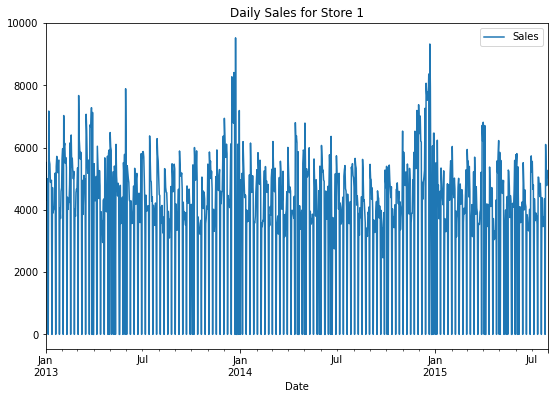

In [6]:
df['Sales'].plot(figsize=(9, 6))
plt.legend(loc='best' )
plt.title('Daily Sales for Store 1')
print(df['Sales'].max())
print(df['Sales'].isna().sum())

1130
0


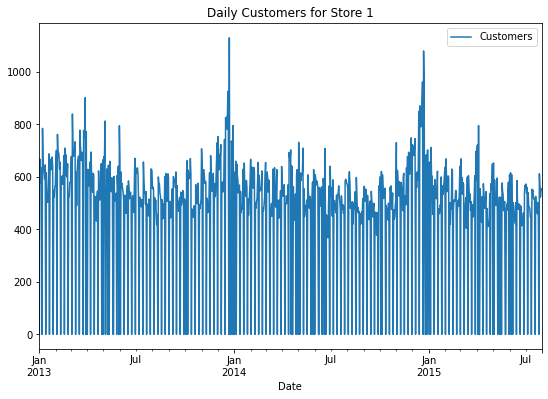

In [7]:
df['Customers'].plot(figsize=(9, 6))
plt.legend(loc='best' )
plt.title('Daily Customers for Store 1')
print(df['Customers'].max())
print(df['Customers'].isna().sum())

In [8]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -4.37
p-value for Sales: 0.00
ADF Statistic for Customers: -3.70
p-value for Customers: 0.00


The p-value is less than .05, we reject the null hypothesis of the ADF test.
We can assume that the trend is stationary.

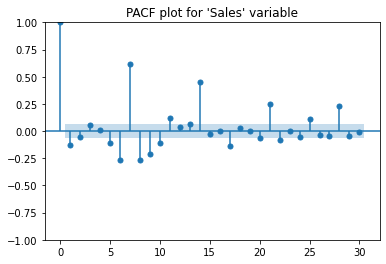

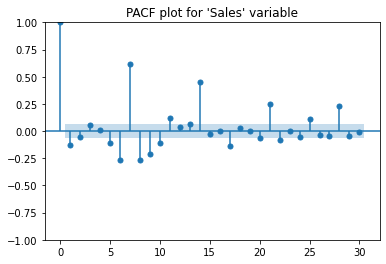

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(df['Sales'].values, title = "PACF plot for 'Sales' variable")

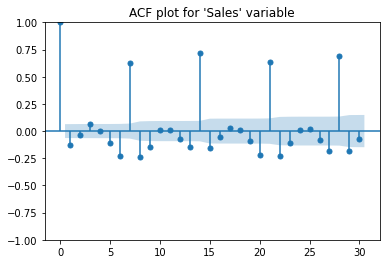

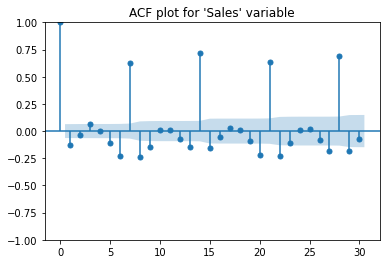

In [10]:
plot_acf(df['Sales'].values, title = "ACF plot for 'Sales' variable")

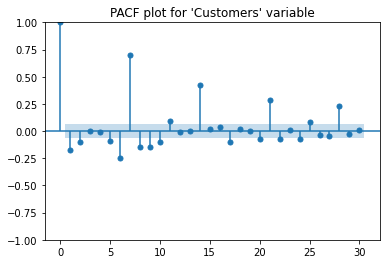

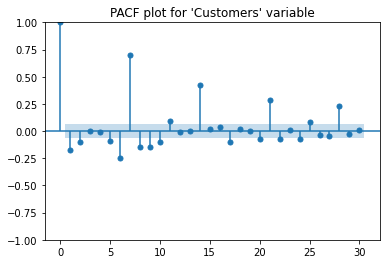

In [11]:
plot_pacf(df['Customers'].values, title = "PACF plot for 'Customers' variable")

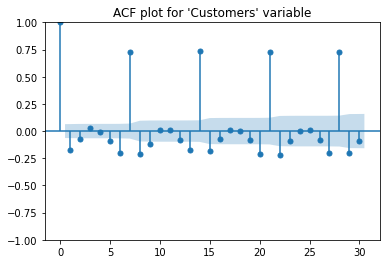

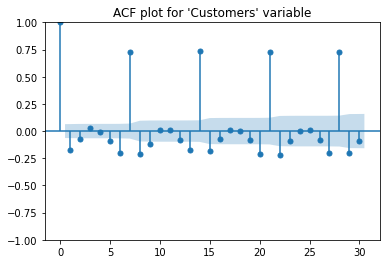

In [12]:
plot_acf(df['Customers'].values, title = "ACF plot for 'Customers' variable")

In [13]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 17)
(43, 17)


In [14]:
%%time
results = []

# Loop over p, d, and q values
for p in range(7):  # from 0 to 7
    for d in range(2):  # typically 0, 1 or 2
        for q in range(7):  # from 0 to 7
            try:
                mod = sm.tsa.ARIMA(train['Sales'].astype('float32'), order=(p,d,q))
                res = mod.fit()
                
                results.append({'p': p, 'd': d, 'q': q, 'AIC': res.aic, 'BIC': res.bic})

            except Exception as e:
                print(f"Error on (p,d,q) = ({p},{d},{q}): {str(e)}")
                continue

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort by AIC to find the best model
sorted_results = results_df.sort_values(by='AIC').reset_index(drop=True)
print(sorted_results)

best_row = sorted_results.iloc[0]
print(f"Best order (p,d,q): ({best_row['p']}, {best_row['d']}, {best_row['q']}) with AIC: {best_row['AIC']}")

    p  d  q           AIC           BIC
0   6  1  6  15562.725169  15625.127380
1   6  0  5  15584.289800  15646.706480
2   6  1  5  15588.945249  15646.547290
3   6  0  6  15617.561567  15684.779529
4   6  0  4  15635.030982  15692.646378
.. .. .. ..           ...           ...
93  5  1  0  16407.265716  16436.066737
94  3  1  0  16415.457758  16434.658438
95  2  1  0  16479.213469  16493.613979
96  1  1  0  16651.077702  16660.678042
97  0  1  0  16958.323108  16963.123278

[98 rows x 5 columns]
Best order (p,d,q): (6.0, 1.0, 6.0) with AIC: 15562.725168826677
CPU times: total: 1min 34s
Wall time: 1min 49s


In [15]:
#running var model
arima_mod = sm.tsa.ARIMA(train['Sales'].astype('float32'), order=(6, 1, 6))
arima_res = arima_mod.fit()

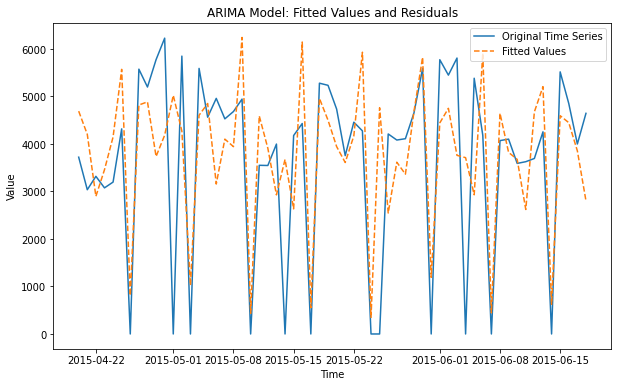

In [16]:
arima_pred = arima_res.fittedvalues

arima_df = pd.DataFrame(arima_pred).rename(columns={0:'Sales'}).reset_index().set_index('Date')


# Plot the original time series, fitted values, and residuals
plt.figure(figsize=(10, 6))
plt.plot(train['Sales'][-60:], label='Original Time Series')
plt.plot(arima_df['Sales'][-60:], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals['Sales'][-20:], label='Residuals', linestyle='dotted')
plt.legend()
plt.title('ARIMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

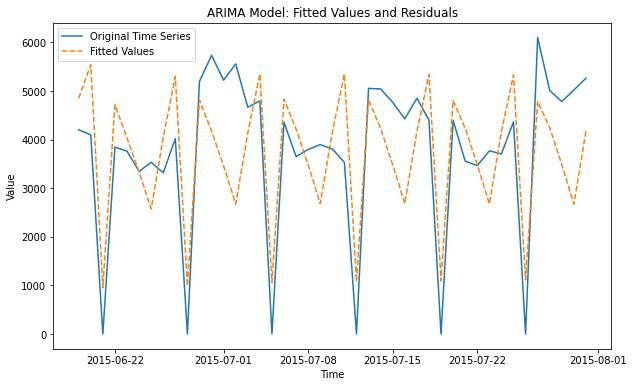

In [17]:
arima_forecast = arima_res.forecast(steps=len(test))
arima_forecast_df = pd.DataFrame(arima_forecast).rename(columns={'predicted_mean':'Sales'}).reset_index().set_index('index')

plt.figure(figsize=(10, 6))
plt.plot(test['Sales'], label='Original Time Series')
plt.plot(arima_forecast_df['Sales'], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals['Sales'][-20:], label='Residuals', linestyle='dotted')
plt.legend()
plt.title('ARIMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

def compute_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def compute_mape(actual, predicted, epsilon=1e-10):
    # Add a small constant epsilon to the denominator to avoid division by zero
    errors = np.abs((actual - predicted) / (actual + epsilon))
    
    # Exclude data points where actual value is zero
    non_zero_idx = actual != 0
    mape = np.mean(errors[non_zero_idx]) * 100
    
    return mape

rmse_train = compute_rmse(train['Sales'], arima_df['Sales'])
mape_train = compute_mape(train['Sales'], arima_df['Sales'])

rmse_test = compute_rmse(test['Sales'], arima_forecast)
mape_test = compute_mape(test['Sales'], arima_forecast)

print(f"RMSE Train Data: {rmse_train}")
print(f"MAPE Train Data: {mape_train}%")

print(f"RMSE Test Data: {rmse_test}")
print(f"MAPE Test Data: {mape_test}%")

RMSE Train Data: 1368.4387468755021
MAPE Train Data: 18.74572893819016%
RMSE Test Data: 1116.4693195850327
MAPE Test Data: 21.031262522047555%


## VARMA

In [19]:
%%time
results = []
#varmax_trends = ['n','c','t','ct']

# Loop over p nd q values
for p in range(7):  # from 0 to 4
    for q in range(7): # from 0 to 4
        #for trend in varmax_trends:
        try:
            mod = sm.tsa.VARMAX(train[['Sales','Customers']].astype('float32'), order=(p,q))
            res = mod.fit()

            results.append({'p': p, 'q': q, 'AIC': res.aic, 'BIC': res.bic})

        except Exception as e:
            print(f"Error on (p,q) = ({p},{q}): {str(e)}")
            continue

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort by AIC to find the best model
sorted_results = results_df.sort_values(by='AIC').reset_index(drop=True)
print(sorted_results)

best_row = sorted_results.iloc[0]
print(f"Best order (p,d,q): ({best_row['p']}, {best_row['q']}) with AIC: {best_row['AIC']}")

Error on (p,q) = (0,0): Invalid VARMAX(p,q) specification; at least one p,q must be greater than zero.
    p  q           AIC           BIC
0   6  6  24594.603210  24849.071211
1   6  4  24719.200765  24935.258501
2   6  5  24752.788469  24988.051337
3   6  1  24754.305965  24912.748305
4   6  2  24765.111644  24942.759116
5   6  3  24769.018358  24965.870963
6   5  5  24874.174231  25090.231968
7   4  6  24891.953517  25108.011253
8   5  4  24906.614982  25103.467587
9   5  2  24910.753283  25069.195623
10  5  3  24920.171836  25097.819309
11  5  6  24924.183131  25159.446000
12  6  0  24928.467993  25067.705201
13  3  6  24969.808352  25166.660956
14  4  5  24971.852500  25168.705105
15  4  4  24972.319522  25149.966995
16  2  6  24981.919557  25159.567030
17  2  4  24991.094774  25130.331982
18  3  5  25008.315673  25185.963145
19  2  5  25015.437537  25173.879877
20  1  6  25015.657935  25174.100275
21  5  1  25022.593270  25161.830478
22  5  0  25025.493758  25145.525834
23  4  3 

In [20]:
%%time

#running var model
var_mod = sm.tsa.VARMAX(train[['Sales','Customers']].astype('float32'), order=(6, 6))
var_res = var_mod.fit(maxiter=1000, disp=False)

CPU times: total: 37min 10s
Wall time: 28min 54s


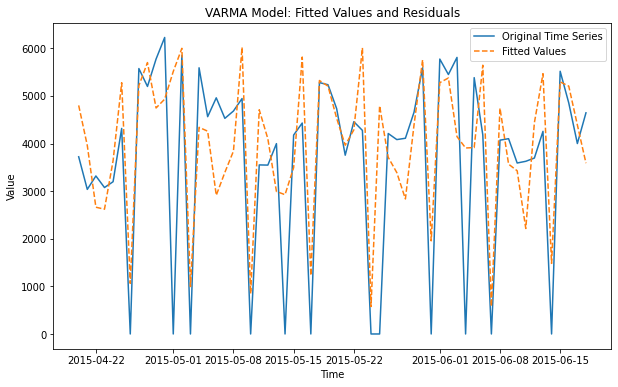

In [21]:
varma_pred = var_res.fittedvalues

# Plot the original time series, fitted values, and residuals
plt.figure(figsize=(10, 6))
plt.plot(train['Sales'][-60:], label='Original Time Series')
plt.plot(varma_pred['Sales'][-60:], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals['Sales'][-20:], label='Residuals', linestyle='dotted')
plt.legend()
plt.title('VARMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

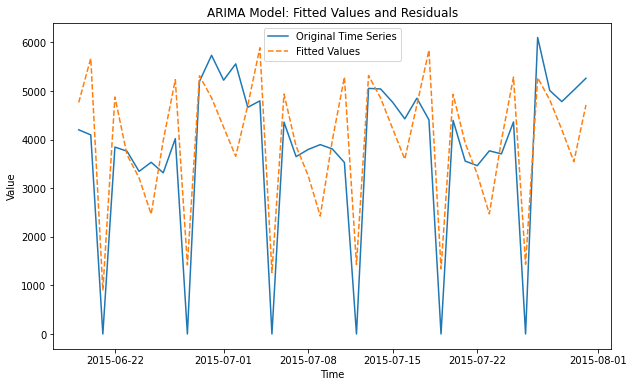

In [22]:
var_forecast = var_res.forecast(steps=len(test))
var_forecast_df = pd.DataFrame(var_forecast).rename(columns={'predicted_mean':'Sales'}).reset_index().set_index('index')

plt.figure(figsize=(10, 6))
plt.plot(test['Sales'], label='Original Time Series')
plt.plot(var_forecast_df['Sales'], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals['Sales'][-20:], label='Residuals', linestyle='dotted')
plt.legend()
plt.title('ARIMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [23]:
rmse_train = compute_rmse(train['Sales'], varma_pred['Sales'])
mape_train = compute_mape(train['Sales'], varma_pred['Sales'])

rmse_test = compute_rmse(test['Sales'], var_forecast['Sales'])
mape_test = compute_mape(test['Sales'], var_forecast['Sales'])

print(f"RMSE Train Data: {rmse_train}")
print(f"MAPE Train Data: {mape_train}%")

print(f"RMSE Test Data: {rmse_test}")
print(f"MAPE Test Data: {mape_test}%")

RMSE Train Data: 1294.0941982036493
MAPE Train Data: 17.800791536887296%
RMSE Test Data: 958.4939106157804
MAPE Test Data: 16.725256561271244%


## XGBoost

In [24]:
%%time

from sklearn.model_selection import GridSearchCV

df_xgb_train, df_xgb_test = train[['Sales']], test[['Sales']]

# Create lag features for the training set
for i in range(1, 7):  # for six lags
    df_xgb_train[f'Sales_lag_{i}'] = df_xgb_train['Sales'].shift(i)

# Drop rows with NaN values in the training set
df_xgb_train.dropna(inplace=True)

# Create lag features for the test set
for i in range(1, 7):  # for six lags
    df_xgb_test[f'Sales_lag_{i}'] = df_xgb_test['Sales'].shift(i)

# Drop rows with NaN values in the test set
df_xgb_test.dropna(inplace=True)

# Define the features for both training and test sets
features = [f'Sales_lag_{i}' for i in range(1, 7)]

# Extract the feature matrices and target values
X_xgb_train = df_xgb_train[features]
X_xgb_test = df_xgb_test[features]
y_xgb_train = df_xgb_train['Sales']
y_xgb_test = df_xgb_test['Sales']

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [0, 0.01]
}

xgb_model1 = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(xgb_model1, param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_xgb_train, y_xgb_train)

# Access the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Create a new XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Fit the best model to the data
eval_set = [(X_xgb_train, y_xgb_train), (X_xgb_test, y_xgb_test)]
best_xgb_model.fit(
    X_xgb_train, y_xgb_train,
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=10,
    verbose=False
)

xgb_train_pred = best_xgb_model.predict(X_xgb_train)
xgb_test_pred = best_xgb_model.predict(X_xgb_test)

rmse_train = compute_rmse(train['Sales'][X_xgb_train.index], xgb_train_pred)
mape_train = compute_mape(train['Sales'][X_xgb_train.index], xgb_train_pred)

rmse_test = compute_rmse(test['Sales'][X_xgb_test.index], xgb_test_pred)
mape_test = compute_mape(test['Sales'][X_xgb_test.index], xgb_test_pred)

print(f"RMSE Train Data: {rmse_train}")
print(f"MAPE Train Data: {mape_train}%")

print(f"RMSE Test Data: {rmse_test}")
print(f"MAPE Test Data: {mape_test}%")

Best Hyperparameters:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.9}
RMSE Train Data: 936.7594322052404
MAPE Train Data: 10.459354883220955%
RMSE Test Data: 1030.6081996113103
MAPE Test Data: 14.321397182330974%
CPU times: total: 34min 21s
Wall time: 3min 7s


## Hybrid

In [25]:
# VARMA - XGBoost

# Create the df_residuals_train and df_residuals_test dataframes once
df_residuals_train = pd.DataFrame(index=var_res.resid.index)
df_residuals_train['Sales_residual'] = var_res.resid['Sales']

df_residuals_test = pd.DataFrame(index=test['Sales'].index)
df_residuals_test['Sales_residual'] = test['Sales'] - var_forecast['Sales']

for i in range(1, 7):  # for six lags
    df_residuals_train[f'Sales_lag_{i}'] = df_residuals_train['Sales_residual'].shift(i)
    df_residuals_test[f'Sales_lag_{i}'] = df_residuals_test['Sales_residual'].shift(i)

# Drop rows with NaN values
df_residuals_train.dropna(inplace=True)
df_residuals_test.dropna(inplace=True)

# Define the features
features = [f'Sales_lag_{i}' for i in range(1, 7)] 

X_residuals_train = df_residuals_train[features]
X_residuals_test = df_residuals_test[features]
y_residuals_train = df_residuals_train[['Sales_residual']]
y_residuals_test = df_residuals_test[['Sales_residual']]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [0, 0.01]
}

xgb_model5 = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(xgb_model5, param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_residuals_train, y_residuals_train)

# Access the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Create a new XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Fit the best model to the data
eval_set = [(X_residuals_train, y_residuals_train), (X_residuals_test, y_residuals_test)]
best_xgb_model.fit(
    X_residuals_train, y_residuals_train,
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=10,
    verbose=False
)

residuals_pred_train = best_xgb_model.predict(X_residuals_train)
residuals_pred_test = best_xgb_model.predict(X_residuals_test)

Best Hyperparameters:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 0.01, 'subsample': 0.8}


In [26]:
rmse_train = compute_rmse(train['Sales'][X_residuals_train.index], residuals_pred_train + var_res.fittedvalues['Sales'][X_residuals_train.index])
mape_train = compute_mape(train['Sales'][X_residuals_train.index], residuals_pred_train + var_res.fittedvalues['Sales'][X_residuals_train.index])

rmse_test = compute_rmse(test['Sales'][X_residuals_test.index], residuals_pred_test + var_forecast['Sales'][-37:])
mape_test = compute_mape(test['Sales'][X_residuals_test.index], residuals_pred_test + var_forecast['Sales'][-37:])

print(f"RMSE Train Data: {rmse_train}")
print(f"MAPE Train Data: {mape_train}%")

print(f"RMSE Test Data: {rmse_test}")
print(f"MAPE Test Data: {mape_test}%")

RMSE Train Data: 907.6556019222213
MAPE Train Data: 12.409680966426508%
RMSE Test Data: 694.7025961653742
MAPE Test Data: 11.956201543990236%


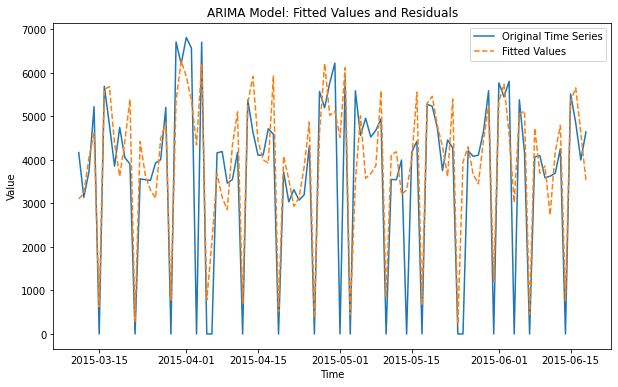

In [27]:
final_train = residuals_pred_train + var_res.fittedvalues['Sales'][X_residuals_train.index]

# Plot the original time series, fitted values, and residuals
plt.figure(figsize=(10, 6))
plt.plot(train['Sales'][-100:], label='Original Time Series')
plt.plot(final_train[-100:], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals, label='Residuals', linestyle='dotted')
plt.legend()
plt.title('ARIMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

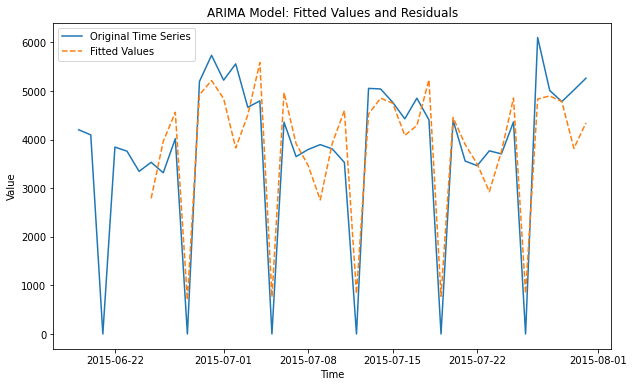

In [28]:
final_pred = residuals_pred_test + var_forecast['Sales'][-37:]

# Plot the original time series, fitted values, and residuals
plt.figure(figsize=(10, 6))
plt.plot(test['Sales'], label='Original Time Series')
plt.plot(final_pred, label='Fitted Values', linestyle='dashed')
#plt.plot(residuals, label='Residuals', linestyle='dotted')
plt.legend()
plt.title('ARIMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## Store 3

RMSE and MAPE for the VARMAX on Sales as above.

In [8]:
df = data[data['Store'] == 3] #filtering out for store 3 data
df = df.asfreq('D')

15689
0


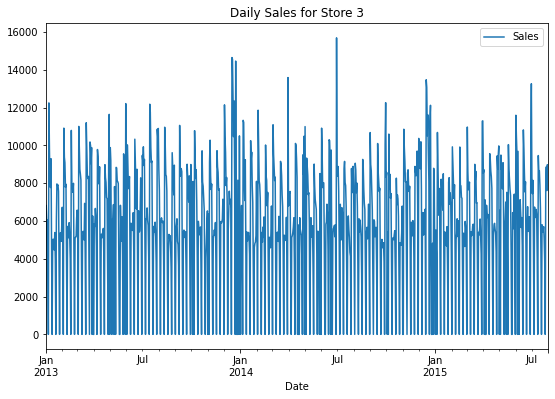

In [9]:
df['Sales'].plot(figsize=(9, 6))
plt.legend(loc='best' )
plt.title('Daily Sales for Store 3')
print(df['Sales'].max())
print(df['Sales'].isna().sum())

1579
0


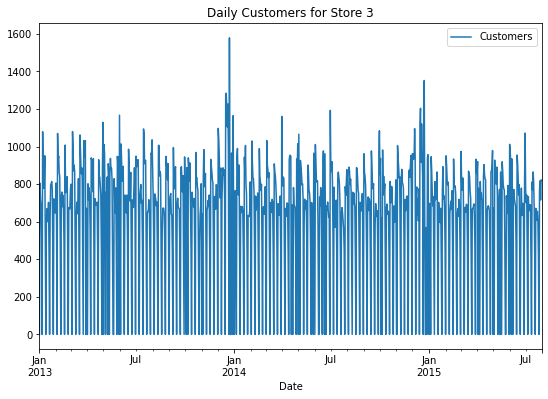

In [10]:
df['Customers'].plot(figsize=(9, 6))
plt.legend(loc='best' )
plt.title('Daily Customers for Store 3')
print(df['Customers'].max())
print(df['Customers'].isna().sum())

In [10]:
# using ADF test to check for stationarity
adf_test = adfuller(df['Sales'])

print("ADF Statistic for Sales: {:.2f}".format(adf_test[0]))
print("p-value for Sales: {:.2f}".format(adf_test[1]))

# using ADF test to check for stationarity
adf_test = adfuller(df['Customers'])

print("ADF Statistic for Customers: {:.2f}".format(adf_test[0]))
print("p-value for Customers: {:.2f}".format(adf_test[1]))

ADF Statistic for Sales: -5.91
p-value for Sales: 0.00
ADF Statistic for Customers: -5.52
p-value for Customers: 0.00


The p-value is less than .05, we reject the null hypothesis of the ADF test. We can assume that the trend is stationary.

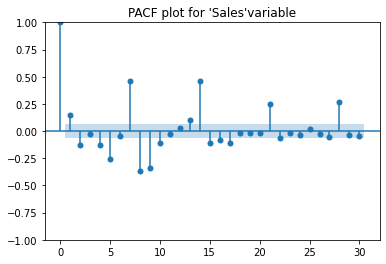

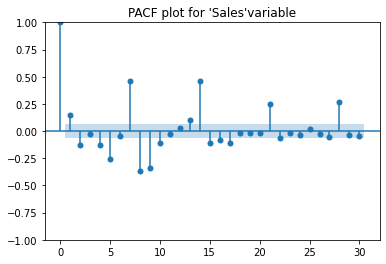

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(df['Sales'].values, title = "PACF plot for 'Sales'variable")

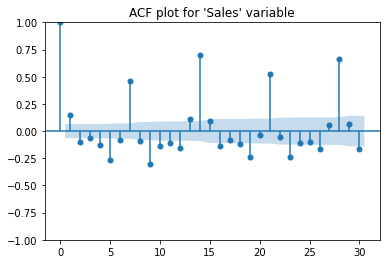

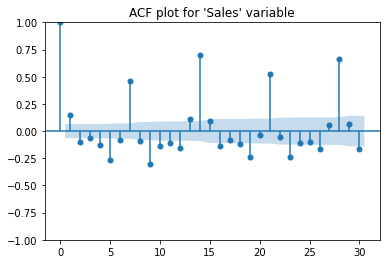

In [12]:
plot_acf(df['Sales'].values, title = "ACF plot for 'Sales' variable")

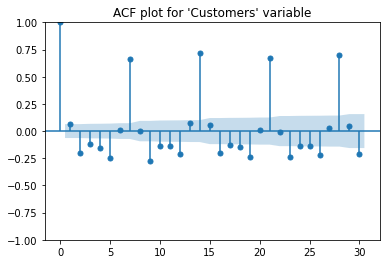

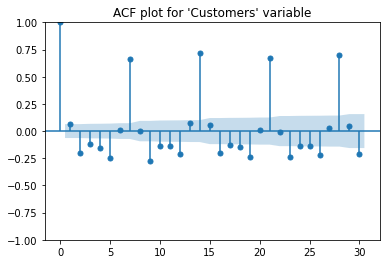

In [13]:
plot_acf(df['Customers'].values, title = "ACF plot for 'Customers' variable")

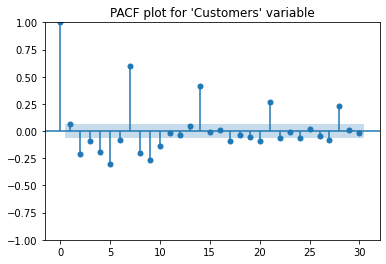

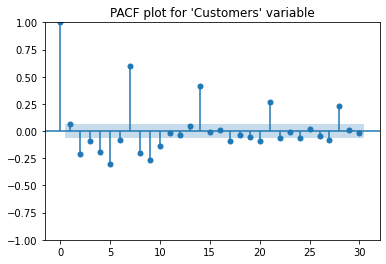

In [14]:
plot_pacf(df['Customers'].values, title = "PACF plot for 'Customers' variable")

In [15]:
train, test = ts_train_test_split(df, period = six_weeks)
print(train.shape)
print(test.shape)

(899, 18)
(43, 18)


In [20]:
%%time
results = []

# Loop over p, d, and q values
for p in range(7):  # from 0 to 9
    for d in range(3):  # typically 0, 1 or 2
        for q in range(7):  # from 0 to 9
            try:
                mod = sm.tsa.ARIMA(train['Sales'].astype('float32'), order=(p,d,q))
                res = mod.fit()
                
                results.append({'p': p, 'd': d, 'q': q, 'AIC': res.aic, 'BIC':res.bic})

            except Exception as e:
                print(f"Error on (p,d,q) = ({p},{d},{q}): {str(e)}")
                continue

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort by AIC to find the best model
sorted_results = results_df.sort_values(by='AIC').reset_index(drop=True)
print(sorted_results)

     p  d  q           AIC           BIC
0    6  0  4  16620.463381  16678.078777
1    6  0  6  16624.168386  16691.386348
2    6  1  4  16629.626133  16682.428004
3    6  1  6  16638.564412  16700.966623
4    5  0  6  16639.257172  16701.673851
..  .. .. ..           ...           ...
142  5  2  0  17666.391880  17695.186215
143  3  2  0  17687.976033  17707.172257
144  2  2  0  17851.596155  17865.993322
145  1  2  0  18109.504122  18119.102234
146  0  2  0  18461.583184  18466.382240

[147 rows x 5 columns]
CPU times: total: 2min 34s
Wall time: 2min 55s


In [21]:
#running var model
arima_mod = sm.tsa.ARIMA(train['Sales'].astype('float32'), order=(6, 0, 4))
arima_res = arima_mod.fit()

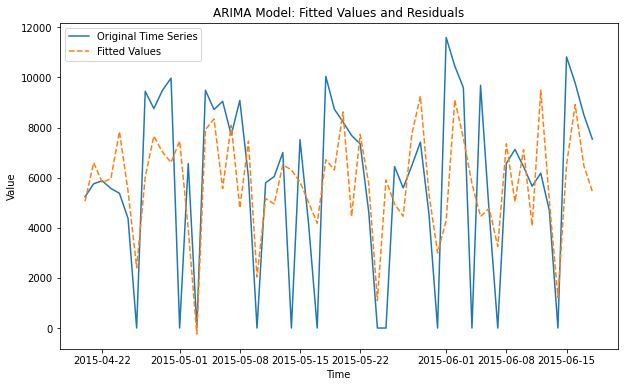

In [22]:
arima_pred = arima_res.fittedvalues

arima_df = pd.DataFrame(arima_pred).rename(columns={0:'Sales'}).reset_index().set_index('Date')

# Plot the original time series, fitted values, and residuals
plt.figure(figsize=(10, 6))
plt.plot(train['Sales'][-60:], label='Original Time Series')
plt.plot(arima_df['Sales'][-60:], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals['Sales'][-20:], label='Residuals', linestyle='dotted')
plt.legend()
plt.title('ARIMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

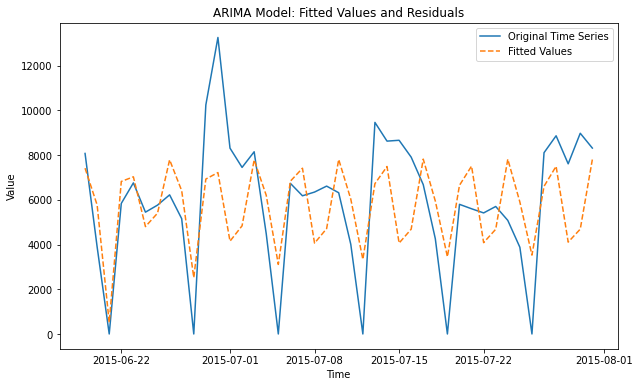

In [23]:
arima_forecast = arima_res.forecast(steps=len(test))
arima_forecast_df = pd.DataFrame(arima_forecast).rename(columns={'predicted_mean':'Sales'}).reset_index().set_index('index')

plt.figure(figsize=(10, 6))
plt.plot(test['Sales'], label='Original Time Series')
plt.plot(arima_forecast_df['Sales'], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals['Sales'][-20:], label='Residuals', linestyle='dotted')
plt.legend()
plt.title('ARIMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error

def compute_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def compute_mape(actual, predicted, epsilon=1e-10):
    # Add a small constant epsilon to the denominator to avoid division by zero
    errors = np.abs((actual - predicted) / (actual + epsilon))
    
    # Exclude data points where actual value is zero
    non_zero_idx = actual != 0
    mape = np.mean(errors[non_zero_idx]) * 100
    
    return mape

rmse_train = compute_rmse(train['Sales'], arima_df['Sales'])
mape_train = compute_mape(train['Sales'], arima_df['Sales'])

rmse_test = compute_rmse(test['Sales'], arima_forecast)
mape_test = compute_mape(test['Sales'], arima_forecast)

print(f"RMSE Train Data: {rmse_train}")
print(f"MAPE Train Data: {mape_train}%")

print(f"RMSE Test Data: {rmse_test}")
print(f"MAPE Test Data: {mape_test}%")

RMSE Train Data: 2469.5576640006284
MAPE Train Data: 24.934524660691523%
RMSE Test Data: 2415.986316212619
MAPE Test Data: 27.959511315273406%


## VARMA

In [25]:
%%time
results = []

# Loop over p nd q values
for p in range(7):  # from 0 to 6
    for q in range(7):  # from 0 to 6
        try:
            mod = sm.tsa.VARMAX(train[['Sales','Customers']].astype('float32'), order=(p,q))
            res = mod.fit()
                
            results.append({'p': p, 'q': q, 'AIC': res.aic, 'BIC':res.bic})

        except Exception as e:
            print(f"Error on (p,q) = ({p},{q}): {str(e)}")
            continue

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort by AIC to find the best model
sorted_results = results_df.sort_values(by='AIC').reset_index(drop=True)
print(sorted_results)

best_row = sorted_results.iloc[0]
print(f"Best order (p,q): ({best_row['p']}, {best_row['q']}) with AIC: {best_row['AIC']}")

Error on (p,q) = (0,0): Invalid VARMAX(p,q) specification; at least one p,q must be greater than zero.
    p  q           AIC           BIC
0   6  6  26212.868815  26467.336816
1   6  3  26356.433293  26553.285897
2   6  2  26363.432424  26541.079897
3   5  5  26374.765761  26590.823497
4   5  2  26384.137485  26542.579825
5   5  3  26387.528647  26565.176119
6   6  5  26388.658739  26623.921607
7   6  4  26389.847497  26605.905234
8   5  4  26406.025157  26602.877761
9   5  6  26437.390728  26672.653597
10  6  1  26537.438012  26695.880352
11  4  5  26551.913127  26748.765732
12  4  3  26586.303210  26744.745550
13  6  0  26592.096472  26731.333680
14  5  1  26630.754880  26769.992088
15  3  6  26634.957000  26831.809604
16  4  4  26635.970294  26813.617767
17  4  6  26637.189369  26853.247106
18  5  0  26640.150122  26760.182198
19  4  2  26750.855051  26890.092259
20  3  5  26776.508364  26954.155836
21  4  1  26785.317277  26905.349353
22  2  6  26797.153026  26974.800498
23  2  5 

In [26]:
%%time

#running var model
var_mod = sm.tsa.VARMAX(train[['Sales','Customers']].astype('float32'), order=(6,6))
var_res = var_mod.fit(maxiter=1000, disp=False)

CPU times: total: 20min 45s
Wall time: 16min 6s


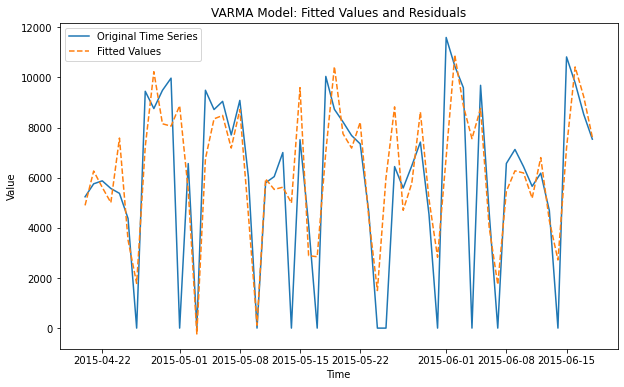

In [27]:
varma_pred = var_res.fittedvalues

# Plot the original time series, fitted values, and residuals
plt.figure(figsize=(10, 6))
plt.plot(train['Sales'][-60:], label='Original Time Series')
plt.plot(varma_pred['Sales'][-60:], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals['Sales'][-20:], label='Residuals', linestyle='dotted')
plt.legend()
plt.title('VARMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

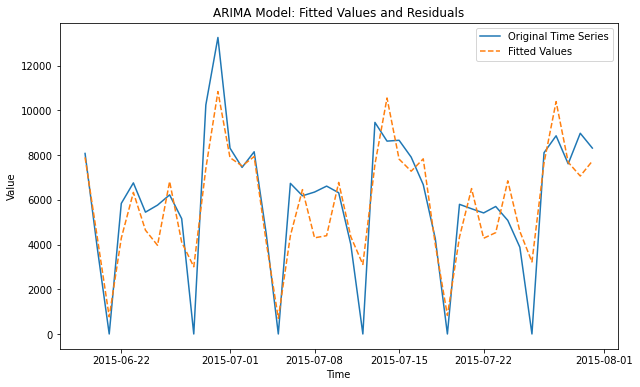

In [28]:
var_forecast = var_res.forecast(steps=len(test))
var_forecast_df = pd.DataFrame(var_forecast).rename(columns={'predicted_mean':'Sales'}).reset_index().set_index('index')

plt.figure(figsize=(10, 6))
plt.plot(test['Sales'], label='Original Time Series')
plt.plot(var_forecast_df['Sales'], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals['Sales'][-20:], label='Residuals', linestyle='dotted')
plt.legend()
plt.title('ARIMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [29]:
rmse_train = compute_rmse(train['Sales'], varma_pred['Sales'])
mape_train = compute_mape(train['Sales'], varma_pred['Sales'])

rmse_test = compute_rmse(test['Sales'], var_forecast['Sales'])
mape_test = compute_mape(test['Sales'], var_forecast['Sales'])

print(f"RMSE Train Data: {rmse_train}")
print(f"MAPE Train Data: {mape_train}%")

print(f"RMSE Test Data: {rmse_test}")
print(f"MAPE Test Data: {mape_test}%")

RMSE Train Data: 2039.485824406647
MAPE Train Data: 18.232330499176776%
RMSE Test Data: 1477.2863726502158
MAPE Test Data: 15.624086863362702%


## XGBoost

In [30]:
%%time

from sklearn.model_selection import GridSearchCV

df_xgb_train, df_xgb_test = train[['Sales']], test[['Sales']]

# Create lag features for the training set
for i in range(1, 7):  # for six lags
    df_xgb_train[f'Sales_lag_{i}'] = df_xgb_train['Sales'].shift(i)

# Drop rows with NaN values in the training set
df_xgb_train.dropna(inplace=True)

# Create lag features for the test set
for i in range(1, 7):  # for six lags
    df_xgb_test[f'Sales_lag_{i}'] = df_xgb_test['Sales'].shift(i)

# Drop rows with NaN values in the test set
df_xgb_test.dropna(inplace=True)

# Define the features for both training and test sets
features = [f'Sales_lag_{i}' for i in range(1, 7)]

# Extract the feature matrices and target values
X_xgb_train = df_xgb_train[features]
X_xgb_test = df_xgb_test[features]
y_xgb_train = df_xgb_train['Sales']
y_xgb_test = df_xgb_test['Sales']

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [0, 0.01]
}

xgb_model1 = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(xgb_model1, param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_xgb_train, y_xgb_train)

# Access the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Create a new XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Fit the best model to the data
eval_set = [(X_xgb_train, y_xgb_train), (X_xgb_test, y_xgb_test)]
best_xgb_model.fit(
    X_xgb_train, y_xgb_train,
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=10,
    verbose=False
)

xgb_train_pred = best_xgb_model.predict(X_xgb_train)
xgb_test_pred = best_xgb_model.predict(X_xgb_test)

rmse_train = compute_rmse(train['Sales'][X_xgb_train.index], xgb_train_pred)
mape_train = compute_mape(train['Sales'][X_xgb_train.index], xgb_train_pred)

rmse_test = compute_rmse(test['Sales'][X_xgb_test.index], xgb_test_pred)
mape_test = compute_mape(test['Sales'][X_xgb_test.index], xgb_test_pred)

print(f"RMSE Train Data: {rmse_train}")
print(f"MAPE Train Data: {mape_train}%")

print(f"RMSE Test Data: {rmse_test}")
print(f"MAPE Test Data: {mape_test}%")

Best Hyperparameters:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.8}
RMSE Train Data: 1327.4882326293894
MAPE Train Data: 10.649814027746833%
RMSE Test Data: 1241.750288093814
MAPE Test Data: 10.601683308473923%
CPU times: total: 31min 58s
Wall time: 3min 10s


## Hybrid

In [31]:
# VARMA - XGBoost

# Create the df_residuals_train and df_residuals_test dataframes once
df_residuals_train = pd.DataFrame(index=var_res.resid.index)
df_residuals_train['Sales_residual'] = var_res.resid['Sales']

df_residuals_test = pd.DataFrame(index=test['Sales'].index)
df_residuals_test['Sales_residual'] = test['Sales'] - var_forecast['Sales']

for i in range(1, 7):  # for six lags
    df_residuals_train[f'Sales_lag_{i}'] = df_residuals_train['Sales_residual'].shift(i)
    df_residuals_test[f'Sales_lag_{i}'] = df_residuals_test['Sales_residual'].shift(i)

# Drop rows with NaN values
df_residuals_train.dropna(inplace=True)
df_residuals_test.dropna(inplace=True)

# Define the features
features = [f'Sales_lag_{i}' for i in range(1, 7)] 

X_residuals_train = df_residuals_train[features]
X_residuals_test = df_residuals_test[features]
y_residuals_train = df_residuals_train[['Sales_residual']]
y_residuals_test = df_residuals_test[['Sales_residual']]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [0, 0.01]
}

xgb_model5 = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(xgb_model5, param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform grid search
grid_search.fit(X_residuals_train, y_residuals_train)

# Access the best hyperparameters from GridSearchCV
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Create a new XGBoost model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)

# Fit the best model to the data
eval_set = [(X_residuals_train, y_residuals_train), (X_residuals_test, y_residuals_test)]
best_xgb_model.fit(
    X_residuals_train, y_residuals_train,
    eval_set=eval_set,
    eval_metric="rmse",
    early_stopping_rounds=10,
    verbose=False
)

residuals_pred_train = best_xgb_model.predict(X_residuals_train)
residuals_pred_test = best_xgb_model.predict(X_residuals_test)

Best Hyperparameters:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 0, 'subsample': 0.8}


In [32]:
rmse_train = compute_rmse(train['Sales'][X_residuals_train.index], residuals_pred_train + var_res.fittedvalues['Sales'][X_residuals_train.index])
mape_train = compute_mape(train['Sales'][X_residuals_train.index], residuals_pred_train + var_res.fittedvalues['Sales'][X_residuals_train.index])

rmse_test = compute_rmse(test['Sales'][X_residuals_test.index], residuals_pred_test + var_forecast['Sales'][-37:])
mape_test = compute_mape(test['Sales'][X_residuals_test.index], residuals_pred_test + var_forecast['Sales'][-37:])

print(f"RMSE Train Data: {rmse_train}")
print(f"MAPE Train Data: {mape_train}%")

print(f"RMSE Test Data: {rmse_test}")
print(f"MAPE Test Data: {mape_test}%")

RMSE Train Data: 1863.6275232845749
MAPE Train Data: 17.277294930629786%
RMSE Test Data: 1521.3364102863848
MAPE Test Data: 15.607177820154872%


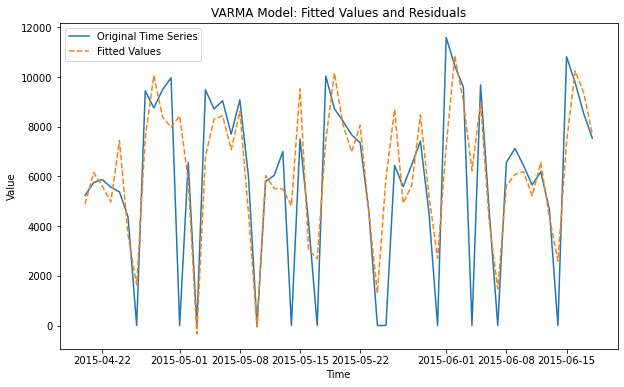

In [33]:
varma_hybrid_df = pd.DataFrame(residuals_pred_train + var_res.fittedvalues['Sales'][X_residuals_train.index], columns=['Sales'], index= X_residuals_train.index)

# Plot the original time series, fitted values, and residuals
plt.figure(figsize=(10, 6))
plt.plot(train['Sales'][-60:], label='Original Time Series')
plt.plot(varma_hybrid_df[-60:], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals['Sales'][-20:], label='Residuals', linestyle='dotted')
plt.legend()
plt.title('VARMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

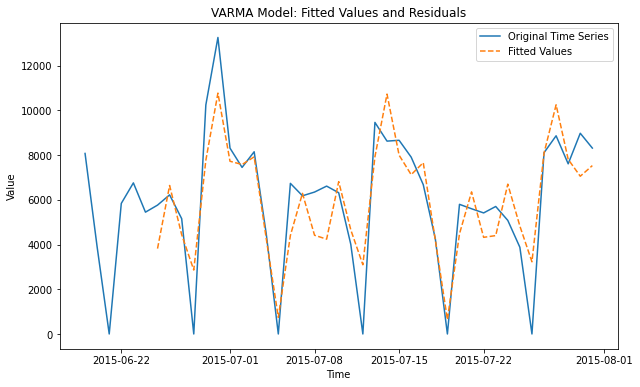

In [34]:
xgb_test_df = pd.DataFrame(residuals_pred_test + var_forecast['Sales'][-37:], columns=['Sales'], index=X_residuals_test.index)

# Plot the original time series, fitted values, and residuals
plt.figure(figsize=(10, 6))
plt.plot(test['Sales'], label='Original Time Series')
plt.plot(xgb_test_df['Sales'], label='Fitted Values', linestyle='dashed')
#plt.plot(residuals['Sales'][-20:], label='Residuals', linestyle='dotted')
plt.legend()
plt.title('VARMA Model: Fitted Values and Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

## The End